# 1. Import Library

In [1]:
import os

import tensorflow as tf
import keras 
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from keras.api.applications import EfficientNetB0
from pathlib import Path

In [2]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# 2. Load data using `keras.preprocessing.image_dataset_from_directory`

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CPU_FLOW = os.cpu_count() 

In [3]:
data_dir ='../Dataset/BellPepperDisease'
train_dir = data_dir + "/train"
val_dir = data_dir + "/val"
test_dir = data_dir + "/test"

In [4]:
train_dataset = keras.preprocessing.image_dataset_from_directory(directory=train_dir, 
                                                           shuffle=True, 
                                                           image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                           batch_size=BATCH_SIZE,
                                                            label_mode="categorical")
val_dataset = keras.preprocessing.image_dataset_from_directory(directory=val_dir, 
                                                           shuffle=True, 
                                                           image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                           batch_size=BATCH_SIZE, label_mode="categorical")
test_dataset = keras.preprocessing.image_dataset_from_directory(directory=test_dir, 
                                                           shuffle=True, 
                                                           image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                           batch_size=BATCH_SIZE, label_mode="categorical")

Found 1000 files belonging to 2 classes.
Found 745 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
class_names = train_dataset.class_names

In [6]:
print(class_names)

['bacterial_spot', 'healthy']


In [8]:
for img_batch, label_batch in train_dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


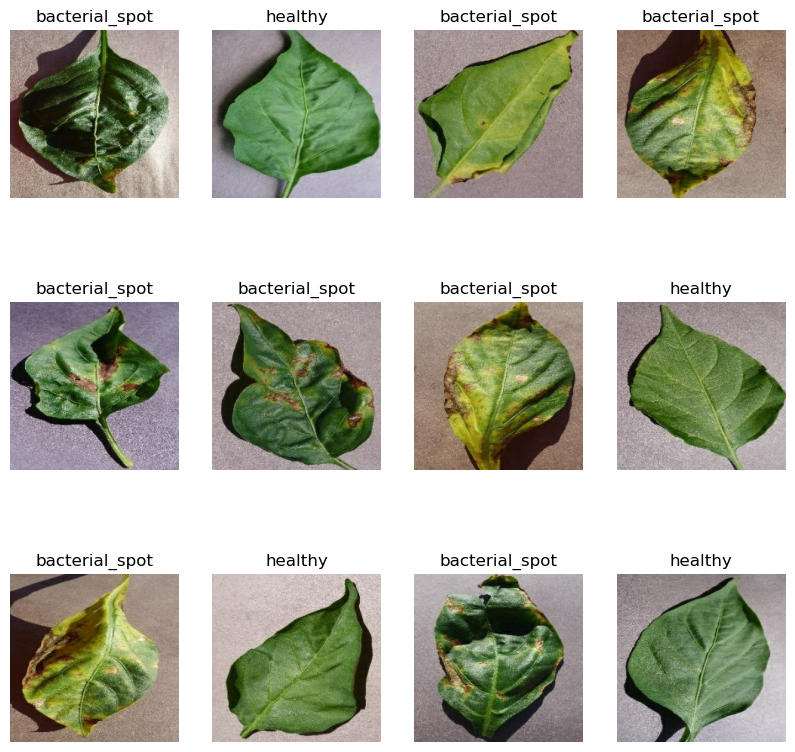

In [9]:
plt.figure(figsize=(10, 10))
for img_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        label = tf.argmax(label_batch[i]).numpy()
        
        plt.title(class_names[int(label)])
        plt.axis('off')

In [10]:
data_augmentation = models.Sequential([
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
])
train_data_augmentation = test_dataset.map(
    lambda x, y : (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [149]:
len(train_dataset)

35

# 4. Cache, Shuffle, and Prefetch the Dataset

In [150]:
train_dataset.cache().shuffle(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset.cache().shuffle(32).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# 5. Model

## 5.1 Transfer Learning with EfficientNetB0

In [11]:
backbone = EfficientNetB0(input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3),
                                               include_top=False,
                                               weights="imagenet")

In [12]:
_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE, 3), name="Input")
x = backbone(_input)
x = layers.GlobalAveragePooling2D()(x)
x= layers.BatchNormalization()(x)
x= layers.Dense(512, activation=tf.nn.silu, 
                         kernel_regularizer = keras.regularizers.l2(1e-5))(x)
x= layers.Dropout(0.2)(x)
x= layers.Dense(256, activation=tf.nn.silu, 
                         kernel_regularizer = keras.regularizers.l2(1e-5))(x)
x= layers.Dropout(0.2)(x)
x = layers.Dense(len(class_names), activation="softmax", name="classification")(x)

model = keras.Model(inputs=[_input], outputs =[x], name="BellPepperDisease_classification")

In [14]:
model.summary()

Model: "PotatoDisease_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,842,405 (18.47 MB)

 Trainable params: 4,797,822 (18.30 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [15]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
tf.config.run_functions_eagerly(False)
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset)

Epoch 1/100
 1/35 ━━━━━━━━━━━━━━━━━━━━ 48:39 86s/step - accuracy: 0.2500 - loss: 1.3706

W0000 00:00:1720884580.100455     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8242 - loss: 0.3899   

W0000 00:00:1720884649.873612     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720884656.366331     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.8268 - loss: 0.3854 - val_accuracy: 0.8047 - val_loss: 0.6885
Epoch 2/100


W0000 00:00:1720884665.495005     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9701 - loss: 0.1270 - val_accuracy: 0.5535 - val_loss: 3.6944
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9830 - loss: 0.0623 - val_accuracy: 0.5349 - val_loss: 2.0112
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9802 - loss: 0.0988 - val_accuracy: 0.9860 - val_loss: 0.0617
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9861 - loss: 0.0686 - val_accuracy: 0.8977 - val_loss: 0.3113
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9980 - loss: 0.0220 - val_accuracy: 0.9628 - val_loss: 0.0677
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9947 - loss: 0.0269 - val_accuracy: 0.9907 - val_loss: 0.0275
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9952 - loss: 0.0361 - val_accuracy: 0.9628 - val_loss: 0.0987
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9737 - loss: 0.0838 - val_accuracy: 0.9907

In [ ]:
scores = model.evaluate(test_dataset)
print(scores)

# 6. Plotting the Accuracy and Loss Curves

In [134]:
history =history.history

In [135]:
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']


In [136]:
# Setup for plotting
labels = ['Training', 'Validation']
data_plot = [{
    'title' : 'Accuracy',
    'train_data' : train_acc,
    'val_data' : val_acc
    
}, {
    'title' : 'Loss',
    'train_data' : train_loss,
    'val_data' : val_loss
    
}
]

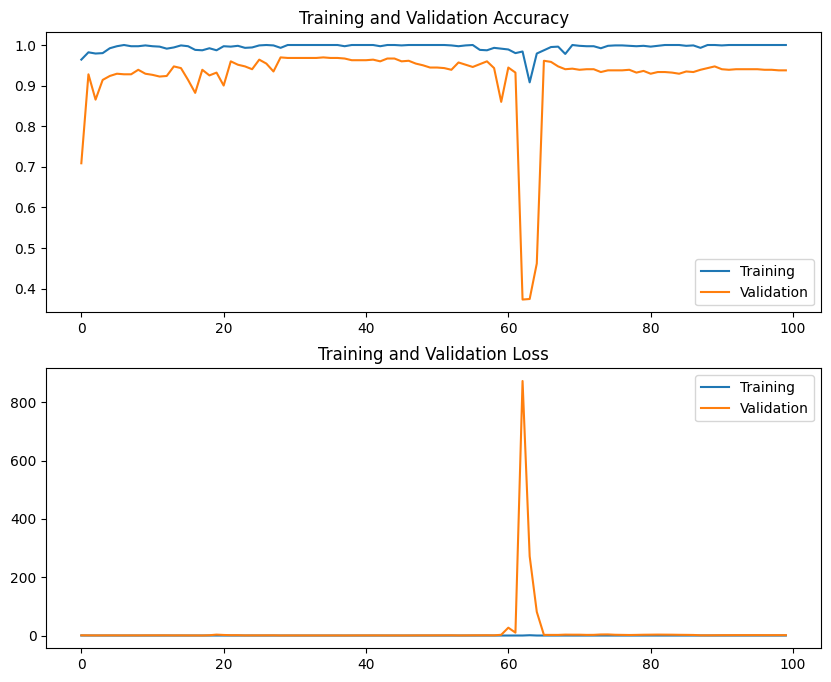

In [137]:
EPOCHS = 100
plt.figure(figsize=(10, 8))
for i in range(len(data_plot)):
    plt.subplot(2, 1, i+1)
    plt.plot(range(EPOCHS), data_plot[i]['train_data'], label=labels[0])
    plt.plot(range(EPOCHS), data_plot[i]['val_data'], label=labels[1])
    plt.title(f'Training and Validation {data_plot[i]["title"]}')
    plt.legend( loc='lower right' if i == 0 else 'upper right')
    

# 7. Run prediction on a sample image

First image to predict
actual label: bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


W0000 00:00:1720884332.498442     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


predicted label: bacterial_spot


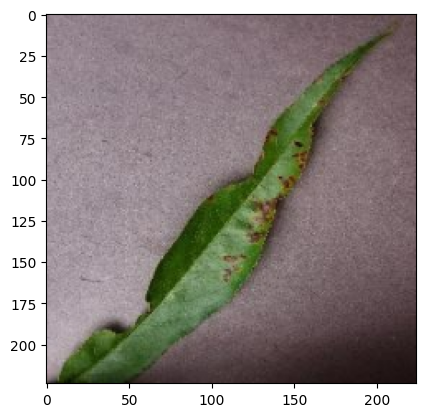

In [138]:
for img_batch, label_batch in test_dataset.take(1):
    img = img_batch[0].numpy().astype('uint8')
    label = tf.argmax(label_batch[i]).numpy()
        
    print("First image to predict")
    plt.imshow(img)
    print("actual label:",class_names[int(label)])
    
    batch_prediction = model.predict(img_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# 8. Write function for inference

In [21]:
def predict_disease(mode :models.Sequential, img):
    img_arr = keras.preprocessing.image.img_to_array(img)
    img_arr = tf.expand_dims(img, 0)

    prediction = model.predict(img_arr, verbose=False)
    pred_class = class_names[np.argmax(prediction[0])]
    
    confidence = round(100*(np.max(prediction[0])), 2)
    
    return pred_class, confidence

## 8.1 Now run inference on few sample image

In [ ]:
def inference_predict(root_dir, model, limited=200):
    path_imgs = [str(x) for x in Path(root_dir).glob("*/*.jpg")]
    np.random.shuffle(path_imgs)
    path_imgs = path_imgs[:limited]
    len_path = len(path_imgs)
    col = 4
    row = len_path // col +1
    plt.figure(figsize=(20, row*5))
    for i, path in enumerate(path_imgs):
        plt.subplot(row, col, i+1)
        img_raw = tf.io.read_file(path)
        img_tensor = tf.image.decode_image(img_raw)

        img_tensor = tf.image.resize(img_tensor, [224, 224]).numpy()

        plt.imshow(img_tensor.astype("uint8"))

        pred_class, confidence = predict_disease(model, img_tensor)
        actual_class = path.split("\\")[-2]

        plt.title(f"Actual: {actual_class},\n Predicted: {pred_class}.\n Confidence: {confidence}%")
        plt.axis('off')
inference_predict(test_dir, model)

# 9.Saving the Model 

In [142]:
model.export(f"./SavedModel/{model.name}")
model.save(f"./Model/{model.name}.h5")

Saved artifact at './Model/PeachDisease_classification'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='Input')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  136163396006512: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136165859947824: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136163394704432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163394701088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163394711296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163394704960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163394706192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163394818064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163394816304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163394822816: TensorSpec(shape=(), dtype=tf.resourc